In [16]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

tf.random.set_seed(1)

# [Module 60 creating and viewing classification data to model](https://youtu.be/tpCFfeUEGs8?t=33008)

### types of classification problems:
1. binary
2. multi-class
3. multi-label

In [6]:
from sklearn.datasets import make_circles

# make 100 samples
n_samples = 1000

# create circles
x, y = make_circles(n_samples, noise=0.03, random_state=1)

In [7]:
# check out features and labels. Output is 1 or 0, so it's binary classification
print(x[:10])
print(y[:10])

[[ 0.83619806  0.03563148]
 [-0.53059757 -0.6487148 ]
 [ 0.85386881 -0.61156583]
 [-0.09214707 -0.9651441 ]
 [-1.00162344  0.14446653]
 [ 0.47605284 -0.61169413]
 [-0.96305328 -0.15441694]
 [-0.54158547 -0.5311938 ]
 [-0.70570924 -0.6354933 ]
 [ 0.83579856  0.580793  ]]
[1 1 0 0 0 1 0 1 0 0]


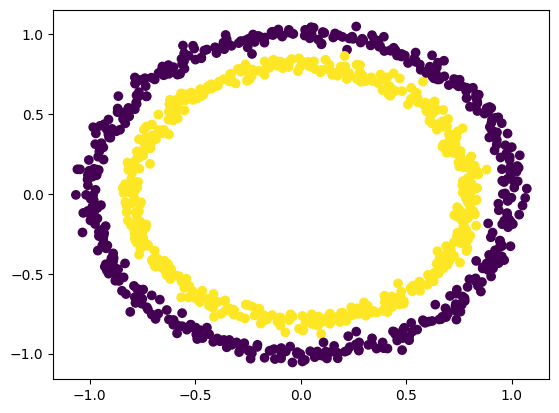

In [13]:
# put it in a dataframe for exploratory analysis
circles = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], "label": y})
# print(circles)
plt.scatter(circles["x0"], circles["x1"], c=y)
plt.show()

# [Module 61 checking the input and output shapes of our NN](https://youtu.be/tpCFfeUEGs8?t=33699)

In [15]:
# shapes:
print(x.shape, y.shape)
print(len(x), len(y))
# first example of features and labels
print(x[0], y[0])

(1000, 2) (1000,)
1000 1000
[0.83619806 0.03563148] 1


### Steps in classification problem
1. turn data into tensors (done for this problem)
2. build model
3. fit model
4. evaluate model
5. tinker with model

# [Module 62 making a non very good NN](https://youtu.be/tpCFfeUEGs8?t=33977)

In [ ]:
# build model

# compile

# fit data

# predict